<a href="https://colab.research.google.com/github/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/NeuroAI_Course/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/student/W1D3_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# Tutorial 2: Computation as transformation of representational geometries

**Week 1, Day 3: Comparing Artificial And Biological Networks**

**By Neuromatch Academy**

__Content creators:__ Hossein Adeli

__Content reviewers:__ Samuele Bolotta, Yizhou Chen, RyeongKyung Yoon, Ruiyi Zhang, Lily Chamakura, Patrick Mineault, Hlib Solodzhuk

__Production editors:__ Konstantine Tsafatinos, Ella Batty, Spiros Chavlis, Samuele Bolotta, Hlib Solodzhuk, Patrick Mineault

___


# Tutorial Objectives

*Estimated timing of tutorial: 40 minutes*

In this tutorial, we aim to understand computations in networks as a sequence of transformations of the representation of the input. We'll see that each transformation can remove information, preserve other information, and change the format in which the information is represented.


In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

from IPython.display import IFrame
from ipywidgets import widgets
out = widgets.Output()

link_id = "qmv5r"

with out:
    print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
    display(IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render", width=730, height=410))
display(out)

---
# Setup



In [ ]:
# @title Install dependencies

!pip install -q torch torchvision matplotlib numpy scikit-learn rsatoolbox scipy

In [ ]:
# Standard library imports
from collections import OrderedDict
import logging

# External libraries: General utilities
import argparse
import numpy as np

# PyTorch related imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision.utils import make_grid

# Matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# SciPy for statistical functions
from scipy import stats

# Scikit-Learn for machine learning utilities
from sklearn.decomposition import PCA
from sklearn import manifold

# RSA toolbox specific imports
import rsatoolbox
from rsatoolbox.data import Dataset
from rsatoolbox.rdm.calc import calc_rdm

In [ ]:
# @title Figure settings

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [ ]:
# @title Plotting functions

def sample_images(data_loader, n=5, plot=False):
    """
    Samples a specified number of images from a data loader.

    Inputs:
    - data_loader (torch.utils.data.DataLoader): Data loader containing images and labels.
    - n (int): Number of images to sample per class.
    - plot (bool): Whether to plot the sampled images using matplotlib.

    Outputs:
    - imgs (torch.Tensor): Sampled images.
    - labels (torch.Tensor): Corresponding labels for the sampled images.
    """

    imgs, targets = next(iter(data_loader))

    imgs_o = []
    labels = []
    for value in range(10):
        cat_imgs = imgs[np.where(targets == value)][0:n]
        imgs_o.append(cat_imgs)
        labels.append([value]*len(cat_imgs))

    imgs = torch.cat(imgs_o, dim=0)
    labels = torch.tensor(labels).flatten()

    if plot:
        plt.imshow(torch.moveaxis(make_grid(imgs, nrow=5, padding=0, normalize=False, pad_value=0), 0,-1))
        plt.axis('off')

    return imgs, labels


def plot_rdms(model_rdms):
    """
    Plots the Representational Dissimilarity Matrices (RDMs) for each layer of a model.

    Inputs:
    - model_rdms (dict): A dictionary where keys are layer names and values are the corresponding RDMs.
    """

    with plt.xkcd():
        fig = plt.figure(figsize=(8, 4))
        gs = fig.add_gridspec(1, len(model_rdms))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        for l in range(len(model_rdms)):

            layer = list(model_rdms.keys())[l]
            rdm = np.squeeze(model_rdms[layer])

            if len(rdm.shape) < 2:
                rdm = rdm.reshape( (int(np.sqrt(rdm.shape[0])), int(np.sqrt(rdm.shape[0]))) )

            rdm = rdm / np.max(rdm)

            ax = plt.subplot(gs[0,l])
            ax_ = ax.imshow(rdm, cmap='magma_r')
            ax.set_title(f'{layer}')

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        cbar_ax.text(-1.6, 0.05, 'Normalized euclidean distance', size=12, rotation=90)
        fig.colorbar(ax_, cax=cbar_ax)

        plt.show()

def rep_path(model_features, model_colors, labels=None, rdm_calc_method='euclidean', rdm_comp_method='cosine'):
    """
    Represents paths of model features in a reduced-dimensional space.

    Inputs:
    - model_features (dict): Dictionary containing model features for each model.
    - model_colors (dict): Dictionary mapping model names to colors for visualization.
    - labels (array-like, optional): Array of labels corresponding to the model features.
    - rdm_calc_method (str, optional): Method for calculating RDMS ('euclidean' or 'correlation').
    - rdm_comp_method (str, optional): Method for comparing RDMS ('cosine' or 'corr').
    """
    with plt.xkcd():
        path_len = []
        path_colors = []
        rdms_list = []
        ax_ticks = []
        tick_colors = []
        model_names = list(model_features.keys())
        for m in range(len(model_names)):
            model_name = model_names[m]
            features = model_features[model_name]
            path_colors.append(model_colors[model_name])
            path_len.append(len(features))
            ax_ticks.append(list(features.keys()))
            tick_colors.append([model_colors[model_name]]*len(features))
            rdms, _ = calc_rdms(features, method=rdm_calc_method)
            rdms_list.append(rdms)

        path_len = np.insert(np.cumsum(path_len),0,0)

        if labels is not None:
            rdms, _ = calc_rdms({'labels' : F.one_hot(labels).float().to(device)}, method=rdm_calc_method)
            rdms_list.append(rdms)
            ax_ticks.append(['labels'])
            tick_colors.append(['m'])
            idx_labels = -1

        rdms = rsatoolbox.rdm.concat(rdms_list)

        #Flatten the list
        ax_ticks = [l for model_layers in ax_ticks for l in model_layers]
        tick_colors = [l for model_layers in tick_colors for l in model_layers]
        tick_colors = ['k' if tick == 'input' else color for tick, color in zip(ax_ticks, tick_colors)]

        rdms_comp = rsatoolbox.rdm.compare(rdms, rdms, method=rdm_comp_method)
        if rdm_comp_method == 'cosine':
            rdms_comp = 1 - rdms_comp
        rdms_comp = np.nan_to_num(rdms_comp, nan=0.0)

        # Symmetrize
        rdms_comp = (rdms_comp + rdms_comp.T) / 2.0

        # reduce dim to 2
        transformer = manifold.MDS(n_components = 2, max_iter=1000, n_init=10, normalized_stress='auto', dissimilarity="precomputed")
        dims= transformer.fit_transform(rdms_comp)

        # remove duplicates of the input layer from multiple models
        remove_duplicates = np.where(np.array(ax_ticks) == 'input')[0][1:]
        for index in remove_duplicates:
            del ax_ticks[index]
            del tick_colors[index]
            rdms_comp = np.delete(np.delete(rdms_comp, index, axis=0), index, axis=1)

        fig = plt.figure(figsize=(8, 4))
        gs = fig.add_gridspec(1, 2)
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        ax = plt.subplot(gs[0,0])
        ax_ = ax.imshow(rdms_comp, cmap='viridis_r')
        fig.subplots_adjust(left=0.2)
        cbar_ax = fig.add_axes([-0.01, 0.2, 0.01, 0.5])
        #cbar_ax.text(-7, 0.05, 'dissimilarity between rdms', size=10, rotation=90)
        fig.colorbar(ax_, cax=cbar_ax,location='left')
        ax.set_title('Dissimilarity between layer rdms')
        ax.set_xticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7, rotation=83)
        ax.set_yticks(np.arange(len(ax_ticks)), labels=ax_ticks, fontsize=7)
        [t.set_color(i) for (i,t) in zip(tick_colors, ax.xaxis.get_ticklabels())]
        [t.set_color(i) for (i,t) in zip(tick_colors, ax.yaxis.get_ticklabels())]

        ax = plt.subplot(gs[0,1])
        amin, amax = dims.min(), dims.max()
        amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8

        for i in range(len(rdms_list)-1):

            path_indices = np.arange(path_len[i], path_len[i+1])
            ax.plot(dims[path_indices, 0], dims[path_indices, 1], color=path_colors[i], marker='.')
            ax.set_title('Representational geometry path')
            ax.set_xlim([amin, amax])
            ax.set_ylim([amin, amax])
            ax.set_xlabel(f"dim 1")
            ax.set_ylabel(f"dim 2")

        # if idx_input is not None:
        idx_input = 0
        ax.plot(dims[idx_input, 0], dims[idx_input, 1], color='k', marker='s')

        if labels is not None:
            ax.plot(dims[idx_labels, 0], dims[idx_labels, 1], color='m', marker='*')

        ax.legend(model_names, fontsize=8)
        fig.tight_layout()

def plot_dim_reduction(model_features, labels, transformer_funcs):
    """
    Plots the dimensionality reduction results for model features using various transformers.

    Inputs:
    - model_features (dict): Dictionary containing model features for each layer.
    - labels (array-like): Array of labels corresponding to the model features.
    - transformer_funcs (list): List of dimensionality reduction techniques to apply ('PCA', 'MDS', 't-SNE').
    """
    with plt.xkcd():

        transformers = []
        for t in transformer_funcs:
            if t == 'PCA': transformers.append(PCA(n_components=2))
            if t == 'MDS': transformers.append(manifold.MDS(n_components = 2, normalized_stress='auto'))
            if t == 't-SNE': transformers.append(manifold.TSNE(n_components = 2, perplexity=40, verbose=0))

        fig = plt.figure(figsize=(8, 2.5*len(transformers)))
        # and we add one plot per reference point
        gs = fig.add_gridspec(len(transformers), len(model_features))
        fig.subplots_adjust(wspace=0.2, hspace=0.2)

        return_layers = list(model_features.keys())

        for f in range(len(transformer_funcs)):

            for l in range(len(return_layers)):
                layer =  return_layers[l]
                feats = model_features[layer].detach().cpu().flatten(1)
                feats_transformed= transformers[f].fit_transform(feats)

                amin, amax = feats_transformed.min(), feats_transformed.max()
                amin, amax = (amin + amax) / 2 - (amax - amin) * 5/8, (amin + amax) / 2 + (amax - amin) * 5/8
                ax = plt.subplot(gs[f,l])
                ax.set_xlim([amin, amax])
                ax.set_ylim([amin, amax])
                ax.axis("off")
                #ax.set_title(f'{layer}')
                if f == 0: ax.text(0.5, 1.12, f'{layer}', size=16, ha="center", transform=ax.transAxes)
                if l == 0: ax.text(-0.3, 0.5, transformer_funcs[f], size=16, ha="center", transform=ax.transAxes)
                # Create a discrete color map based on unique labels
                num_colors = len(np.unique(labels))
                cmap = plt.get_cmap('viridis_r', num_colors) # 10 discrete colors
                norm = mpl.colors.BoundaryNorm(np.arange(-0.5,num_colors), cmap.N)
                ax_ = ax.scatter(feats_transformed[:, 0], feats_transformed[:, 1], c=labels, cmap=cmap, norm=norm)

        fig.subplots_adjust(right=0.9)
        cbar_ax = fig.add_axes([1.01, 0.18, 0.01, 0.53])
        fig.colorbar(ax_, cax=cbar_ax, ticks=np.linspace(0,9,10))
        plt.show()

In [ ]:
# @title Helper functions

import contextlib
import io

class Net(nn.Module):
    """
    A neural network model for image classification, consisting of two convolutional layers,
    followed by two fully connected layers with dropout regularization.

    Methods:
    - forward(input): Defines the forward pass of the network.
    """

    def __init__(self):
        """
        Initializes the network layers.

        Layers:
        - conv1: First convolutional layer with 1 input channel, 32 output channels, and a 3x3 kernel.
        - conv2: Second convolutional layer with 32 input channels, 64 output channels, and a 3x3 kernel.
        - dropout1: Dropout layer with a dropout probability of 0.25.
        - dropout2: Dropout layer with a dropout probability of 0.5.
        - fc1: First fully connected layer with 9216 input features and 128 output features.
        - fc2: Second fully connected layer with 128 input features and 10 output features.
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, input):
        """
        Defines the forward pass of the network.

        Inputs:
        - input (torch.Tensor): Input tensor of shape (batch_size, 1, height, width).

        Outputs:
        - output (torch.Tensor): Output tensor of shape (batch_size, 10) representing the class probabilities for each input sample.
        """
        x = self.conv1(input)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

class recurrent_Net(nn.Module):
    """
    A recurrent neural network model for image classification, consisting of two convolutional layers
    with recurrent connections and a readout layer.

    Methods:
    - __init__(time_steps=5): Initializes the network layers and sets the number of time steps for recurrence.
    - forward(input): Defines the forward pass of the network.
    """

    def __init__(self, time_steps=5):
        """
        Initializes the network layers and sets the number of time steps for recurrence.

        Layers:
        - conv1: First convolutional layer with 1 input channel, 16 output channels, and a 3x3 kernel with a stride of 3.
        - conv2: Second convolutional layer with 16 input channels, 16 output channels, and a 3x3 kernel with padding of 1.
        - readout: A sequential layer containing:
            - dropout: Dropout layer with a dropout probability of 0.25.
            - avgpool: Adaptive average pooling layer to reduce spatial dimensions to 1x1.
            - flatten: Flatten layer to convert the 2D pooled output to 1D.
            - linear: Fully connected layer with 16 input features and 10 output features.
        - time_steps (int): Number of time steps for the recurrent connection.
        """
        super(recurrent_Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 3)
        self.conv2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.readout = nn.Sequential(OrderedDict([
            ('dropout', nn.Dropout(0.25)),
            ('avgpool', nn.AdaptiveAvgPool2d(1)),
            ('flatten', nn.Flatten()),
            ('linear', nn.Linear(16, 10))
        ]))
        self.time_steps = time_steps

    def forward(self, input):
        """
        Defines the forward pass of the network.

        Inputs:
        - input (torch.Tensor): Input tensor of shape (batch_size, 1, height, width).

        Outputs:
        - output (torch.Tensor): Output tensor of shape (batch_size, 10) representing the class probabilities for each input sample.
        """
        input = self.conv1(input)
        x = input
        for t in range(0, self.time_steps):
            x = input + self.conv2(x)
            x = F.relu(x)

        x = self.readout(x)
        output = F.softmax(x, dim=1)
        return output


def train_one_epoch(args, model, device, train_loader, optimizer, epoch):
    """
    Trains the model for one epoch.

    Inputs:
    - args (Namespace): Arguments for training configuration.
    - model (torch.nn.Module): The model to be trained.
    - device (torch.device): The device to use for training (CPU/GPU).
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    - epoch (int): The current epoch number.
    """
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

def test(model, device, test_loader, return_features=False):
    """
    Evaluates the model on the test dataset.

    Inputs:
    - model (torch.nn.Module): The model to be evaluated.
    - device (torch.device): The device to use for evaluation (CPU/GPU).
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test data.
    - return_features (bool): If True, returns the features from the model. Default is False.
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def build_args():
    """
    Builds and parses command-line arguments for training.
    """
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=2, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--no-mps', action='store_true', default=False,
                        help='disables macOS GPU training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args('')

    use_cuda = torch.cuda.is_available() #not args.no_cuda and

    if use_cuda:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    args.use_cuda = use_cuda
    args.device = device
    return args

def fetch_dataloaders(args):
    """
    Fetches the data loaders for training and testing datasets.

    Inputs:
    - args (Namespace): Parsed arguments with training configuration.

    Outputs:
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training data.
    - test_loader (torch.utils.data.DataLoader): DataLoader for the test data.
    """
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if args.use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    with contextlib.redirect_stdout(io.StringIO()): #to suppress output
        dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
        dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
        train_loader = torch.utils.data.DataLoader(dataset1, **train_kwargs)
        test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
        return train_loader, test_loader

def train_model(args, model, optimizer):
    """
    Trains the model using the specified arguments and optimizer.

    Inputs:
    - args (Namespace): Parsed arguments with training configuration.
    - model (torch.nn.Module): The model to be trained.
    - optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.

    Outputs:
    - None: The function trains the model and optionally saves it.
    """
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train_one_epoch(args, model, args.device, train_loader, optimizer, epoch)
        test(model, args.device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


def calc_rdms(model_features, method='correlation'):
    """
    Calculates representational dissimilarity matrices (RDMs) for model features.

    Inputs:
    - model_features (dict): A dictionary where keys are layer names and values are features of the layers.
    - method (str): The method to calculate RDMs, e.g., 'correlation'. Default is 'correlation'.

    Outputs:
    - rdms (pyrsa.rdm.RDMs): RDMs object containing dissimilarity matrices.
    - rdms_dict (dict): A dictionary with layer names as keys and their corresponding RDMs as values.
    """
    ds_list = []
    for l in range(len(model_features)):
        layer = list(model_features.keys())[l]
        feats = model_features[layer]

        if type(feats) is list:
            feats = feats[-1]

        if args.use_cuda:
            feats = feats.cpu()

        if len(feats.shape) > 2:
            feats = feats.flatten(1)

        feats = feats.detach().numpy()
        ds = Dataset(feats, descriptors=dict(layer=layer))
        ds_list.append(ds)

    rdms = calc_rdm(ds_list, method=method)
    rdms_dict = {list(model_features.keys())[i]: rdms.get_matrices()[i] for i in range(len(model_features))}

    return rdms, rdms_dict

def fgsm_attack(image, epsilon, data_grad):
    """
    Performs FGSM attack on an image.

    Inputs:
    - image (torch.Tensor): Original image.
    - epsilon (float): Perturbation magnitude.
    - data_grad (torch.Tensor): Gradient of the data.

    Outputs:
    - perturbed_image (torch.Tensor): Perturbed image after FGSM attack.
    """
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Converts a batch of normalized tensors to their original scale.

    Inputs:
    - batch (torch.Tensor): Batch of normalized tensors.
    - mean (torch.Tensor or list): Mean used for normalization.
    - std (torch.Tensor or list): Standard deviation used for normalization.

    Outputs:
    - torch.Tensor: Batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(batch.device)
    if isinstance(std, list):
        std = torch.tensor(std).to(batch.device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

def generate_adversarial(model, imgs, targets, epsilon):
    """
    Generates adversarial examples using FGSM attack.

    Inputs:
    - model (torch.nn.Module): The model to attack.
    - imgs (torch.Tensor): Batch of images.
    - targets (torch.Tensor): Batch of target labels.
    - epsilon (float): Perturbation magnitude.

    Outputs:
    - adv_imgs (torch.Tensor): Batch of adversarial images.
    """
    adv_imgs = []

    for img, target in zip(imgs, targets):
        img = img.unsqueeze(0)
        target = target.unsqueeze(0)
        img.requires_grad = True

        output = model(img)
        loss = F.nll_loss(output, target)

        model.zero_grad()
        loss.backward()

        data_grad = img.grad.data
        data_denorm = denorm(img)
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        adv_imgs.append(perturbed_data_normalized.detach())

    return torch.cat(adv_imgs)

def test_adversarial(model, imgs, targets):
    """
    Tests the model on adversarial examples and prints the accuracy.

    Inputs:
    - model (torch.nn.Module): The model to be tested.
    - imgs (torch.Tensor): Batch of adversarial images.
    - targets (torch.Tensor): Batch of target labels.
    """
    correct = 0
    output = model(imgs)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(targets.view_as(pred)).sum().item()

    final_acc = correct / float(len(imgs))
    print(f"adversarial test accuracy = {correct} / {len(imgs)} = {final_acc}")

def extract_features(model, imgs, return_layers, plot='none'):
    """
    Extracts features from specified layers of the model.

    Inputs:
    - model (torch.nn.Module): The model from which to extract features.
    - imgs (torch.Tensor): Batch of input images.
    - return_layers (list): List of layer names from which to extract features.
    - plot (str): Option to plot the features. Default is 'none'.

    Outputs:
    - model_features (dict): A dictionary with layer names as keys and extracted features as values.
    """
    if return_layers == 'all':
        return_layers, _ = get_graph_node_names(model)
    elif return_layers == 'layers':
        layers, _ = get_graph_node_names(model)
        return_layers = [l for l in layers if 'input' in l or 'conv' in l or 'fc' in l]

    feature_extractor = create_feature_extractor(model, return_nodes=return_layers)
    model_features = feature_extractor(imgs)

    return model_features

In [ ]:
# @title Data retrieval

import os
import requests
import hashlib

# Variables for file and download URL
fnames = ["standard_model.pth", "adversarial_model.pth", "recurrent_model.pth"] # The names of the files to be downloaded
urls = ["https://osf.io/s5rt6/download", "https://osf.io/qv5eb/download", "https://osf.io/6hnwk/download"] # URLs from where the files will be downloaded
expected_md5s = ["2e63c2cd77bc9f1fa67673d956ec910d", "25fb34497377921b54368317f68a7aa7", "ee5cea3baa264cb78300102fa6ed66e8"] # MD5 hashes for verifying files integrity

for fname, url, expected_md5 in zip(fnames, urls, expected_md5s):
    if not os.path.isfile(fname):
        try:
            # Attempt to download the file
            r = requests.get(url) # Make a GET request to the specified URL
        except requests.ConnectionError:
            # Handle connection errors during the download
            print("!!! Failed to download data !!!")
        else:
            # No connection errors, proceed to check the response
            if r.status_code != requests.codes.ok:
                # Check if the HTTP response status code indicates a successful download
                print("!!! Failed to download data !!!")
            elif hashlib.md5(r.content).hexdigest() != expected_md5:
                # Verify the integrity of the downloaded file using MD5 checksum
                print("!!! Data download appears corrupted !!!")
            else:
                # If download is successful and data is not corrupted, save the file
                with open(fname, "wb") as fid:
                    fid.write(r.content) # Write the downloaded content to a file

In [ ]:
# @title Set random seed

import random
import numpy as np
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

set_seed(seed = 42)

In [ ]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
    """
    Determines and sets the computational device for PyTorch operations based on the availability of a CUDA-capable GPU.

    Outputs:
    - device (str): The device that PyTorch will use for computations ('cuda' or 'cpu'). This string can be directly used
    in PyTorch operations to specify the device.
    """

    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("GPU is not enabled in this notebook. \n"
              "If you want to enable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `GPU` from the dropdown menu")
    else:
        print("GPU is enabled in this notebook. \n"
              "If you want to disable it, in the menu under `Runtime` -> \n"
              "`Hardware accelerator.` and select `None` from the dropdown menu")

    return device

device = set_device()

---
# Section 1: Computation & representational geometries

We are going to use the same models, standard and adversarially trained, as in the previous tutorial.

In [ ]:
# @markdown Grab a standard model

args = build_args()
train_loader, test_loader = fetch_dataloaders(args)
path = "standard_model.pth"
model = torch.load(path, map_location=args.device)

In order to better visualize the structure of the model features, we grab 5 test images from each of the 10 digit categories. Below is a simple function to perform that. For the purpose of the visualization, we order the test images by category identity.

In [ ]:
# @markdown Just sample 5 per category to show the order

imgs, labels = sample_images(test_loader, n=5, plot=True)

First let's look at the computational steps in the model.

In [ ]:
# @markdown Computational steps

train_nodes, _ = get_graph_node_names(model)
print('The computational steps in the network are: \n', train_nodes)

We now extract the features from the intermediate layers of the model for the sampled test images.

In [ ]:
# @markdown Features for different layers

return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2']
model_features = extract_features(model, imgs.to(device), return_layers=return_layers)
print('features gathered for:', list(model_features.keys()))

## Calculating and plotting the RDMs

Now for each of the test images, we have the model features from each layer of the trained network. We can look at how the representational (dis)similarity between these samples changes across the layers of the network. For each layer, we flatten the features so that each test image is represented by a vector (i.e. a point in space) and then we use the `rsatooblox` to compute the Euclidean distances between the points in that representational space.

The result is a matrix of distances between each pair of samples for each layer.

We can now plot the RDMs for the input pixels, the two convolutional, and the two fully connected layers below.

The RDMs are of dimension `#stimuli` by `#stimuli`. The brighter cells show smaller dissimilarity between the two stimuli. The diagonal has a dissimilarity of 0, as each image is maximally similar to itself.

Since the instances of each category are next to each other, the brighter blocks emerging around the diagonal show that the representations for category instances become similar to one another across the levels of the hierarchy.

In [ ]:
# @markdown Putting it all together

imgs, labels = sample_images(test_loader, n=20) #grab 20 samples from each category

return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2']
model_features = extract_features(model, imgs.to(device), return_layers=return_layers)

rdms, rdms_dict = calc_rdms(model_features)
plot_rdms(rdms_dict)

Computation in the network can be understood as the transformation of representational geometries. As we see in the above RDMs the geometry captures how the representation in later layers becomes more similar for instances of the same category since this model was trained for classification.


## Dimensionality reduction

Another way to examine the geometry of the representation changing across layers is by reducing the dimensionality and displaying the samples in 2D space.

The representational spaces of each layer of a deep network project each stimulus to a point in a very high-dimensional space. Methods such as PCA (principal component analysis), MDS (Multidimensional_scaling), and t-SNE (t-distributed stochastic neighbor embedding) attempt to capture the same geometry in lower dimensions.

Below we look at the representational geometry of the same network layers using these methods.

For this visualization, we take 500 samples from the test set and we color-code them based on their category. The figure below shows the scatter plots for these samples across the layers of the network. Each panel is the 2D projection of the feature representations using a specific method.

The methods all show that image representations progressively cluster based on category across the layers of the network.

In [ ]:
# @markdown Sequential image representation clustering

return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2']
imgs, labels = sample_images(test_loader, n=50) #grab 50 samples from the each category

# Alternatively get a whole test batch
#imgs, labels = next(iter(test_loader))

model_features = extract_features(model, imgs.to(device), return_layers)
plot_dim_reduction(model_features, labels, transformer_funcs =['PCA', 'MDS', 't-SNE'])

## Representational path: from comparing representations to comparing RDMs

We can now go a step further and think of the computational steps in a network as steps in a path in the space of representational geometries. Each layer in the network is changing the geometry to make it more and more like the desired geometry, which are the labels for a network trained for classification. What we'll do is to *[compare RDM matrices](https://rsatoolbox.readthedocs.io/en/stable/comparing.html)* across layers. 

### Comparing RDMs

The first step, as before, is to calculate RDMs based on the Euclidean distances between the representations of images for each layer. We stack these RDMs into a 3d tensor:

$$M(\text{layer i}, \text{image j}, \text{image k})$$

The next step is to quantify how the geometries change across the layers. To perform this operation we first flatten the RDMs to obtain a 2d matrix:

$$\hat M(\text{layer i}, \text{image j x image k})$$

We can then calculate the distances between the different rows of this new matrix. It's like an RDM matrix of the RDM matrices! This new measure of distance captures the representational geometries of different layers,  not the representations themselves.

We compute the similarity between geometries using the cosine dissimilarity. The resulting matrix has the dimensions of `#layers` by `#layers`.

The last step to visualize the path is to embed the distances between the geometries in a lower dimensional space. We use MDS to reduce the dimensions to 2 in order to show each computational step as a point in a 2D space.

The function below plots the computation that takes place across the layers of the network as a path in the space of representational gemoetries.

/tmp/ipykernel_4976/2071329666.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


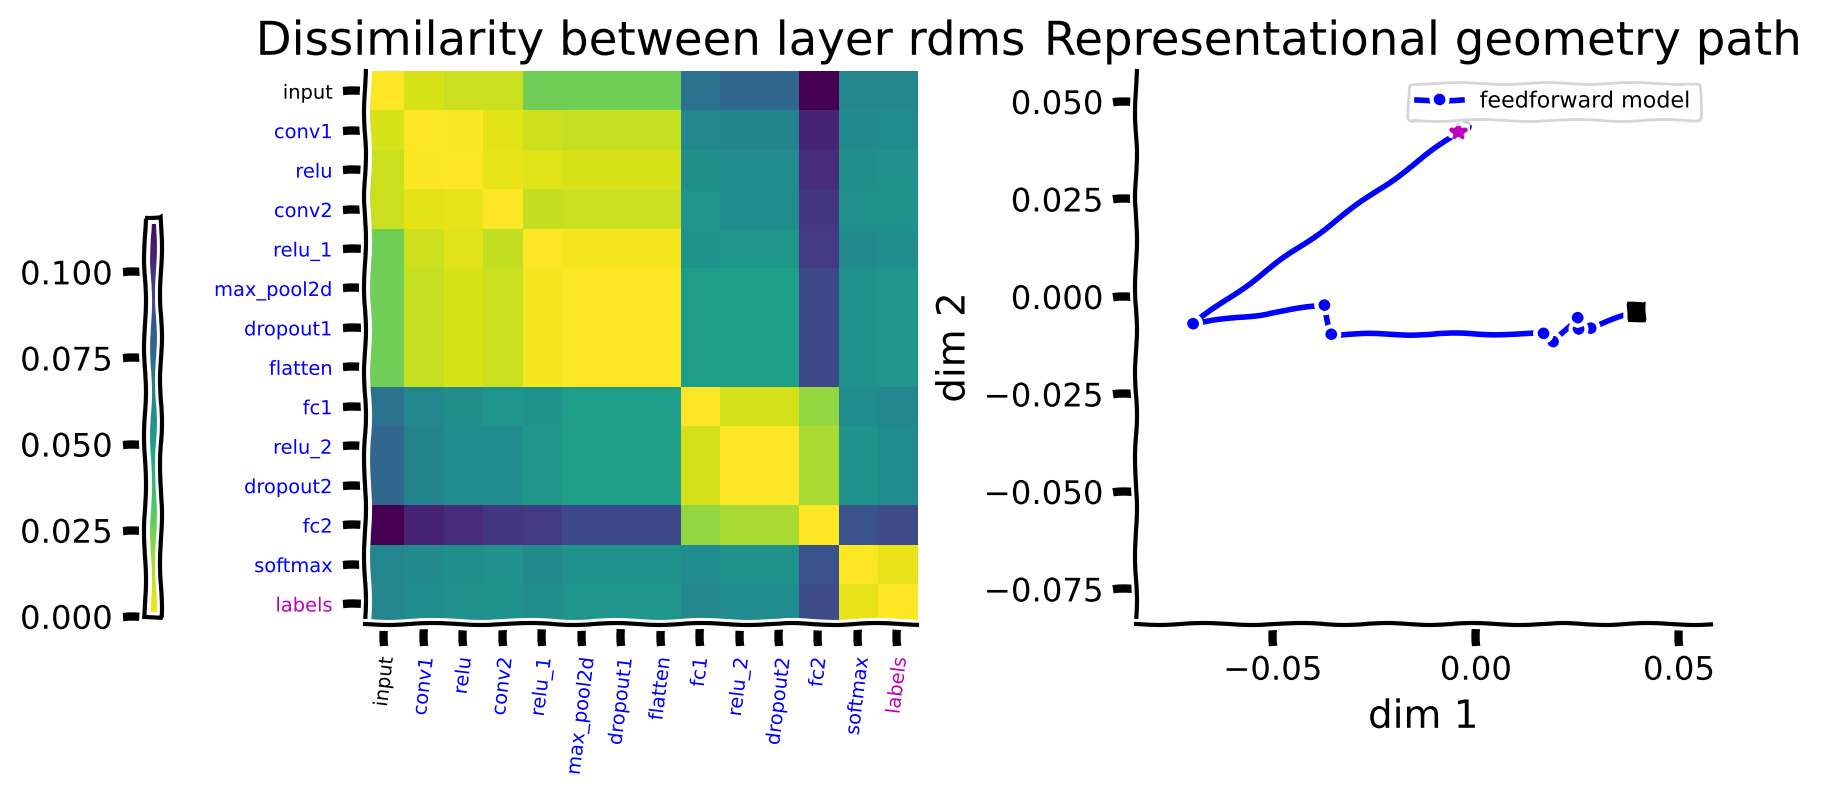

In [16]:
# @markdown Representational Path

imgs, labels = next(iter(test_loader)) #grab 500 samples from the test set

model_features = extract_features(model, imgs.to(device), return_layers='all')

features = {'feedforward model': model_features}
model_colors = {'feedforward model': 'b'}
rep_path(features, model_colors, labels)

The left panel shows the dissimilarities between the RDMs that capture the representational geometry for each layer.

The brighter colors indicate higher similarity. The diagonal is 0, since each layer is maximally similar to itself. The brighter blocks around the diagonal show that distances between blocks of adjacent layers are small.

The figure on the right shows the embedding of these distances in a 2D space using MDS. This figure captures the same distances between the layers shown in the matrix on the left in a 2D space. Connecting the steps starting from the input (shown as the black square) forms a path in the space of representional geometries. The last step in this path (the softmax layer) is similar to the embedding of the labels (denoted by an asterisk) in the same 2D space.

There are a few things to note about the path: 

1. The path is generally smooth. This shows that each layer only slightly changes the representations, which we could also observe from the distance matrix on the left. 
2. The distance between the representational geometry of the input and the labels is large but we see these two points somewhat close to each other in the path. This is partly because MDS tries to optimize to capture all the distances in the 2D space, they cannot all be veridically captured and a stronger curvature is introduced to the path. Therefore details of the curvature in 2D should be interpreted with caution. 
3. The size of the steps is generally informative. For example, we see in the left matrix that there is a big change in the representational geometry going from the convolutional to the fully connected layers, corresponding to a larger step in the path.

Thus the computation performed by this model is a path from the geometry of the input pixels to the geometry of the ground truth labels.

### Think!

1. How do you think the representational path will change if we take a smaller sample of images to create the RDMs?

Let's find out by taking a sample of 5 images per category and visualizing the path.

In [ ]:
# @markdown Test your idea by executing this cell!

#imgs, labels = next(iter(test_loader)) #grab 500 samples from the test set
imgs, labels = sample_images(test_loader, n=5)
model_features = extract_features(model, imgs.to(device), return_layers='all')

features = {'feedforward model': model_features}
model_colors = {'feedforward model': 'b'}
rep_path(features, model_colors, labels)

As you can see the two paths are very similar. Differences such reflections and rotations are not meaningful as different runs of the MDS can vary along such factors. We should judge the general paths of the models to compare them.

## Adversarial images

Adversarial images pose a generalization challange to DNNs. Here we examine how this challenge and lower performance are reflected in the the representational geometry path. First we use FGSM (Fast Gradient Sign method) to generate adversarial images for the trained feedforward model. This is a "white-box" attack that uses the gradients from the model loss with respect to to an image to adjust the image in order to maximize the loss. 


### Representational geometry in standard network

Once again, we can observe the signature of these mistakes reflected in the layer-wise geometry of the representation. When the model is applied to the adversarial images, the rdms no longer show the progressive emergence of block-wise structure strongly around the diagonal.

In [ ]:
# @markdown Extract model features from the adversarial images and plot the new RDMs
imgs, labels = sample_images(test_loader, n=20)
eps = 0.2
adv_imgs = generate_adversarial(model, imgs.to(device), labels.to(device), eps)
return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2'] #inputs/outputs will be added automatically
model_features = extract_features(model, adv_imgs.to(device), return_layers)
rdms, rdms_dict = calc_rdms(model_features)
plot_rdms(rdms_dict)

### Representational geometry in an adversarially trained network

Let's load up an adversarially trained network and verify that it performs well on a newly generated set of adversarial images.

In [ ]:
# @markdown Grab an adversarially robust model

path = "adversarial_model.pth"
model_robust = torch.load(path, map_location=args.device)

In [ ]:
# @markdown Test an adversarially robust model

imgs, labels = sample_images(test_loader, n=20)
adv_imgs = generate_adversarial(model_robust, imgs.to(device), labels.to(device), eps)
test_adversarial(model_robust, adv_imgs.to(device), labels.to(device))

And the structure in the rdms are also restored.

In [ ]:
# @markdown Extract robust model features from the adversarial images and plot the new RDMs

return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2'] #inputs/outputs will be added automatically
model_features = extract_features(model_robust, adv_imgs.to(device), return_layers)
rdms, rdms_dict = calc_rdms(model_features)
plot_rdms(rdms_dict)

### Coding Exercise 1

Use MDS to visualize the changes in the representational geometry across the layers of this network in response to original MNIST test images.

```python
#################################################
# Fill out and remove
raise NotImplementedError("Student exercise: fill in the missing variables")
#################################################

return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2']
imgs, labels = sample_images(test_loader, n=50) # grab 500 samples from the test set
model_features = ...

plot_dim_reduction(model_features, labels, transformer_funcs =['MDS'])

```

In [ ]:
# to_remove solution

return_layers = ['input', 'conv1', 'conv2', 'fc1', 'fc2']
imgs, labels = sample_images(test_loader, n=50) # grab 500 samples from the test set
model_features = extract_features(model_robust, imgs.to(device), return_layers)

plot_dim_reduction(model_features, labels, transformer_funcs =['MDS'])

## Comparing representational geometry paths between models

We can generalize our method to look at the representational geometry paths of multiple models. We will first compute the RDMs for each layer of each network and then concatenate them all. Then we look at the dissimilarity between all the layers (from different models).

In this case, we will be looking at the feedforward and the robust feedforward models. The left panel in the figure below shows the dissimilarity between the representational geometries of all the layers in these two models. Networks are color-coded for clarity, with the original feedforward model shown in blue and the robust feedforward model shown in green. The input pixels are shown again in black and the ground truth labels are in magenta.

Embedding this matrix in a 2D space with MDS again gives us the path that each network took from the input images to the labels.

In this case, they are both tested on the original MNIST test images and both can perform the task. This is reflected in both models reaching the labels.

In [ ]:
imgs, labels = sample_images(test_loader, n=50) #grab 500 samples from the test set

model_features = extract_features(model, imgs.to(device), return_layers='all')
model_features_robust = extract_features(model_robust, imgs.to(device), return_layers='all')

features = {'feedforward model': model_features, 'robust feedforward model': model_features_robust}
model_colors = {'feedforward model': 'b', 'robust feedforward model': 'g'}
rep_path(features, model_colors, labels)

What if we test the models on adversarial images? We can see below that in this case, only the robust model can reach the labels.  

In [ ]:
imgs, labels = sample_images(test_loader, n=50) #grab 500 samples from the test set

adv_imgs = generate_adversarial(model, imgs.to(device), labels.to(device), eps)

model_features = extract_features(model, adv_imgs.to(device), return_layers='all')
model_features_robust = extract_features(model_robust, adv_imgs.to(device), return_layers='all')

features = {'feedforward model': model_features, 'robust feedforward model': model_features_robust}
model_colors = {'feedforward model': 'b', 'robust feedforward model': 'g'}
rep_path(features, model_colors, labels)

When we use adversarial images, the two networks are taking diverging paths in the space of representational geometries. Only the robust model's representation converges towards the embedding of the labels.

We can see from this example that these paths depend on the chosen stimuli!

### Think!

1. Can you identify different aspects of what you see in these paths from the distance matrix on the left?

### Coding Exercise 2

Train another instance of the model on the original MNIST data for only one epoch with a different seed. Then compare the representational paths of the two instances that are both trained on the original MNIST with one another. Display the paths in blue and cyan colors.

```python
#################################################
## TODO for students: fill in the missing variables ##
# Fill out function and remove
raise NotImplementedError("Student exercise: fill in the missing variables")
#################################################

args = build_args()
torch.manual_seed(args.seed+1)
args.epochs = 1
#build_model
model_new_seed = Net().to(device)

optimizer = optim.Adadelta(...)
train_model(args, model_new_seed, optimizer)

```

In [ ]:
# to_remove solution

args = build_args()
torch.manual_seed(args.seed+1)
args.epochs = 1
#build_model
model_new_seed = Net().to(device)

optimizer = optim.Adadelta(model_new_seed.parameters(), lr=args.lr)
train_model(args, model_new_seed, optimizer)

In [ ]:
imgs, labels = sample_images(test_loader, n=50) #grab 500 samples from the test set

model_features = extract_features(model, imgs.to(device), return_layers='all')
model_features_new_seed = extract_features(model_new_seed, imgs.to(device), return_layers='all')

features = {'model': model_features, 'model new seed': model_features_new_seed}
model_colors = {'model': 'b', 'model new seed': 'c'}
rep_path(features, model_colors, labels)

### Think!

1. What is your interpretation of how the two paths compare to each other?

---
# Summary

*Estimated timing of tutorial: 40 minutes*

In this tutorial, we:

- Characterized the computation that happens across different layers of a network as a path with each step gradually changing the geometry of the representation to go from input pixels to target labels.
- Examined the paths for different model architectures and different inputs and learned how to interpret them.

---
# Bonus Section: Representational geometry of recurrent models

Transformations of representations can occur across space and time, e.g. layers of a neural network and steps of recurrent computation.



Just as the layers in a feedforward DNN can change the representational geometry to perform a task, steps in a recurrent network can reuse the same layer to reach the same computational depth.

In this section, we look at a very simple recurrent network with only 2650 trainable parameters.

Here is a diagram of this network:

![Recurrent convolutional neural network](https://github.com/neuromatch/NeuroAI_Course/blob/main/tutorials/W1D3_ComparingArtificialAndBiologicalNetworks/static/rcnn_tutorial.png?raw=true)

In [ ]:
# @markdown Grab a recurrent model

args = build_args()
train_loader, test_loader = fetch_dataloaders(args)
path = "recurrent_model.pth"
model_recurrent = torch.load(path, map_location=args.device)

<br>We can first look at the computational steps in this network. As we see below, the conv2 operation is repeated for 5 times.

In [ ]:
train_nodes, _ = get_graph_node_names(model_recurrent)
print('The computational steps in the network are: \n', train_nodes)

Plotting the rdms after each application of the conv2 operation shows the same progressive emergence of the blockwise structure around the diagonal mediating the correct classification in this task.

In [ ]:
imgs, labels = sample_images(test_loader, n=20)
return_layers = ['conv2', 'conv2_1', 'conv2_2', 'conv2_3', 'conv2_4'] #
model_features = extract_features(model_recurrent, imgs.to(device), return_layers) #, plot = 'rolled'

rdms, rdms_dict = calc_rdms(model_features)
plot_rdms(rdms_dict)

We can also look at how the different dimensionality reduction techniques capture the dynamics of changing geometry.

In [ ]:
return_layers = ['conv2', 'conv2_1', 'conv2_2', 'conv2_3', 'conv2_4']

imgs, labels = sample_images(test_loader, n=50) #grab 500 samples from the test set
model_features = extract_features(model_recurrent, imgs.to(device), return_layers)

plot_dim_reduction(model_features, labels, transformer_funcs =['PCA', 'MDS', 't-SNE'])

## Representational geometry paths for recurrent models

We can look at recurrent computational steps of the model as a path in the representational geometry space.

In [ ]:
imgs, labels = sample_images(test_loader, n=50) #grab 500 samples from the test set
model_features_recurrent = extract_features(model_recurrent, imgs.to(device), return_layers='all')

#rdms, rdms_dict = calc_rdms(model_features)
features = {'recurrent model': model_features_recurrent}
model_colors = {'recurrent model': 'y'}

rep_path(features, model_colors, labels)

We can also look at the paths taken by the feedforward and the recurrent models and compare them.

In [ ]:
imgs, labels = sample_images(test_loader, n=50) #grab 500 samples from the test set
model_features = extract_features(model, imgs.to(device), return_layers='all')
model_features_recurrent = extract_features(model_recurrent, imgs.to(device), return_layers='all')

features = {'feedforward model': model_features, 'recurrent model': model_features_recurrent}
model_colors = {'feedforward model': 'b', 'recurrent model': 'y'}

rep_path(features, model_colors, labels)

What we can see here is that different models can take very different paths in the space of representational geometries to map images to labels. This is because there exist many different functional mappings to do a classification task.